**Dataset Selection**

Select a dataset identically to the way you selected for lab one, lab two, or lab three (table data, text data, or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

**Grading Rubric**

**Preparation** (15 points total)

[5 points] (mostly the same as from lab four) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well should your algorithm perform in order to be useful to third parties. 

[10 points] (mostly the same as from labs one through three) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

**Evaluation** (20 points total)

[10 points] (mostly the same as from lab five) Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] (mostly the same as from lab five) Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

**Modeling** (55 points total)

[35 points] Create a custom ensemble classifier that uses multi-layer perceptron models for the individual classifiers. You can use bagging or boosting to select the training examples for each MLP in the ensemble, whichever you prefer.   

[20 points] Evaluate the performance of the ensemble classifier with your chosen evaluation metric(s). Visualize the results with a confusion matrix, receiver operating characteristic, and area under the curve. Visually compare its performance to the individual classifiers that make up the ensemble.

**Exceptional Work** (10 points total)

You have free reign to provide additional analyses.
One idea: add randomized feature selection to your bagging or boosting models

# Lab 06 - Ensembles

By Erik Gabrielsen, Danh Nguyen, and Conrad Appel

## Business Understanding

In this lab, we are interested in investigating image processing techniques and seeing how well these techniques will work with our custom multilayer perceptron and scikit-learn's. We will be using the CIFAR-10 small images (32x32) dataset, which contains the following labels:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The goal is to have the models predict as well as possible according to the F1 score, since we are interested in seeing how correctly images are classified. The highest score based on accuracy on Kaggle is around .96, but that requires hours and hours of computation time. If we can perform image recognition anywhere near as well with a relatively simple model to implement, then perhaps we have good processing techniques. This project has computer vision applications, and could be applied to robotics and especially people that wants to deploy simple image recognition models without access to large computationally expensive servers. Ideally, we would want our F1 score to be around 90%, so that the majority of images can be accomplished by the computer with some checks by people. 

In [14]:
import os
import sys
import random
import copy
import warnings
from random import randint
import _pickle as cPickle
import pickle
from pathlib import Path

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.neural_network import MLPClassifier
from sklearn.utils.validation import check_X_y, check_array
from scipy.misc import imread
from scipy.special import expit
import pywt # conda install -c conda-forge pywavelets
from skimage.filters import roberts
from skimage.feature import daisy
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score

%matplotlib inline
%load_ext memory_profiler
# plt.style.use('ggplot')

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [15]:
# a helper plotting function
def plot_gallery(imgs, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(imgs[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(labels[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [16]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./imgs/
###

def get_images(): # stuck this in a function to clean up memory    
    dics = []
    for root, directory, files in os.walk('imgs'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(cPickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('./imgs/batches.meta', 'rb') as fo:
        labels_tmp = cPickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_color, img_gray, img_labels, img_label_names)

img_color, img_gray, img_labels, img_label_names = get_images()
img_color = None # clear this memory because my computer ugh
img_gray = img_gray
img_labels = img_labels
print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


### Image Preprocessing
For image processing we tried a multitude of different processing techniques. The first was converting the images from color to grayscale, then using edge-detection to create features for each image. From this pre-processing, we were only able to generate a 30% f1 score with sci-kit learn's MLP classifier. Then on top of this, we tried the python wavelet transform on the images, which only got a slightly better f1 score of 32%. According to Kaggle's leaderboard score, the best score (which was achieved by convolutional neuron networks) was a 95.5% f1 score, and this was a model trained for over 20hrs. According a paper writen by Shouhan Lin, Roland Memisevic, and Kishore Konda, they expiremented the CIFAR-10 dataset and for preprocessing used a "contrast normalization to have a zero mean, followed by PCA whitening, retaining 99% of the variance" (6). Using ReLu Networks with different configurations, they were able to obtain a f1 score of 56.84%. Based off these results, our goal was to obtain a f1 score of around 50%. 
Using our MLP model, we then attempted this preprocessing technique and achieved an f1 score well below 30%. From more research, we attempted to do gray-scale, global contrast normalization on all images followed by ZCA whitening. This resulted in an f1 score of 35%. Since we were still not near our goal, we tried several other techniques, such as daisy feature extraction and color flattening. In addition, we extended color flattening and overlayed the edge-detection on top of that and yielded similar results to edge-detection and gray-scale. 

Finally we discovered that using grayscale and daisy feature extraction, we were consistantly able to get a f1 score of around 57%. Thus we perform daisy feature extraction and gray scale dimensionality reduction. Then we use Standard Scalar in our pipeline to scale down our data.
 
The final dataset looks something like this, where each row is one image in gray scale. Daisy feature extraction is performed at the end:

In [ ]:
plot_gallery(img_gray, img_label_names, 32, 32) 

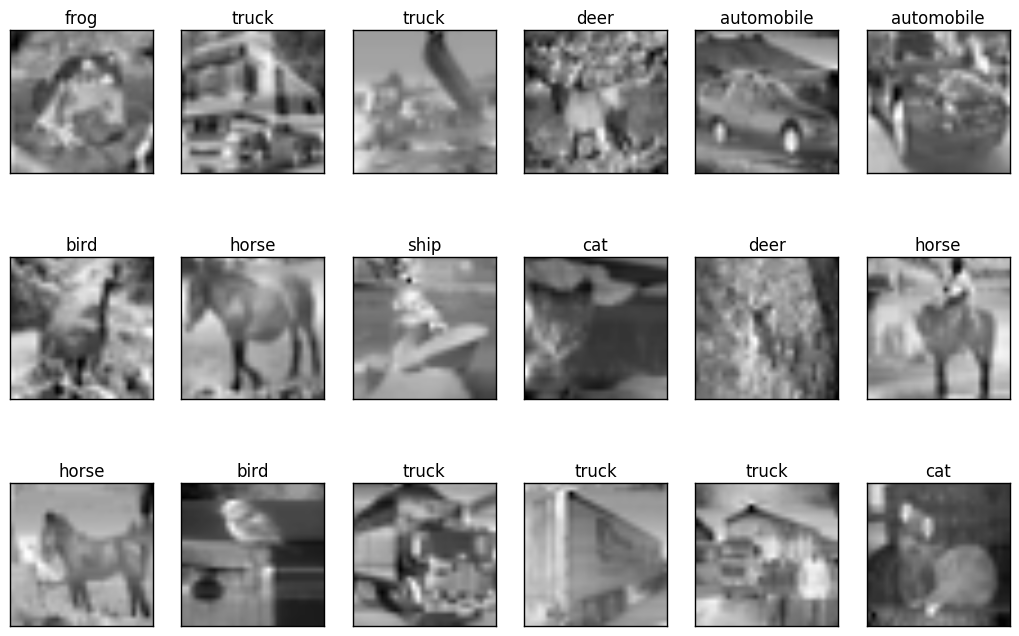

In [17]:
def global_contrast_normalization(x):
    x = x - x.mean(axis=1)[:, np.newaxis]
    normalizers = np.sqrt((x ** 2).sum(axis=1))
    x /= normalizers[:, np.newaxis]
    return x

# contrast normalization
normalized = np.array([np.concatenate(global_contrast_normalization(x.reshape((32, 32)))) for x in img_gray])
plot_gallery(normalized, img_label_names, 32, 32) 

In [18]:
my_file = Path('./imgs/cached_daisies')
if my_file.is_file():
    with open('./imgs/cached_daisies', 'rb') as f:
        daisies = pickle.load(f)
else:
    daisies = np.array([np.concatenate(np.concatenatte(daisy(x.reshape((32,32)), step=16, radius=7, rings=2, histograms=8, orientations=5))) for x in img_gray])
    with open('./imgs/cached_daisies', 'wb+') as f:
        pickle.dump(daisies, f)

## Modeling

In [19]:
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=20, samp_percent=.25, replacement=False, weighted=True, proba_voting=False):
        super().__init__()
        self.n_estimators = n_estimators
        self.samp_percent = samp_percent
        self.replacement = replacement
        self.weighted = weighted
        self.proba_voting = proba_voting
        
    def _get_subset(self, x, y, replacement=True, samp_percent=.25, return_other=False):
        xy = np.hstack([x, y.reshape((len(y),1))])
        np.random.shuffle(xy)
        size = int(len(y)*samp_percent) if not replacement else len(y)
        indexes = np.random.choice(range(len(y)), size=size, replace=replacement)
        
        new_x = xy[indexes][:, :-1]
        new_y = xy[indexes][:, -1]
        
        if not return_other:
            return new_x, new_y
        else:
            inv_indexes = [i for i in range(len(xy)) if i not in indexes]
            alternate_x = xy[inv_indexes][:, :-1]
            alternate_y = xy[inv_indexes][:, -1]
            return new_x, new_y, alternate_x, alternate_y
        
        
    def fit(self, x, y, print_progress=False):
        x, y = check_X_y(x, y)
        x, y = x.copy(), y.copy()
        
        self.classifiers_ = []
        self.precisions_ = []
        self.n_features_ = x.shape[1]
        self.n_classes_ = len(np.unique(y))
        self.classes_, y = np.unique(y, return_inverse=True)            
        
        for i in range(self.n_estimators):
            if print_progress:
                sys.stdout.write('Estimator '+str(i)+' fitting.....')
            new_x, new_y, alt_x, alt_y = self._get_subset(x, y, return_other=True, replacement=self.replacement, samp_percent=self.samp_percent)
            c = MLPClassifier()
            c.fit(new_x, new_y)
            self.classifiers_.append(c)
            if print_progress:
                sys.stdout.write('testing.....')
            self.precisions_.append(f1_score(alt_y, c.predict(alt_x), average='weighted'))
            if print_progress:
                sys.stdout.write('complete!\n')
        
        return self
    
    def predict(self, x):
        x = check_array(x)
            
        results = np.zeros((x.shape[0], self.n_classes_))
        for classifier, precision in zip(self.classifiers_, self.precisions_):
            if self.proba_voting:
                res = classifier.predict_proba(x)
                results += res * (precision if self.weighted else 1)
            else:
                res = classifier.predict(x).astype(np.int)
                for i in range(len(res)):
                    results[i][res[i]] += precision if self.weighted else 1
        
        # select highest picked class for each row
        res = [np.argmax(x) for x in results]
        res = self.classes_[res]

        return res

In [20]:
p2 = Pipeline([('scaler', StandardScaler()), ('tlp', EnsembleClassifier(n_estimators=2, replacement=False, proba_voting=True))])
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
for train_index, test_index in cv.split(daisies, img_labels):
    p2.fit(daisies[train_index], img_labels[train_index], tlp__print_progress=True)
    yhat = p2.predict(daisies[test_index])
    print('f1 score:', f1_score(img_labels[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

Estimator 0 fitting.....testing.....complete!
Estimator 1 fitting.....testing.....complete!
f1 score: 0.525771758051
[1167 1275 1185 1135 1231 1090 1239 1323 1202 1153]


## Evaluation

In [ ]:
x = daisies
y = img_labels

In [ ]:
cv = StratifiedShuffleSplit(n_splits=3, test_size=.2)

params =  dict(n_hidden=100, 
      C=0.05, # tradeoff L2 regularizer
      epochs=200, # iterations
      eta=0.0001,  # learning rate
      random_state=1,
      cost_func="cross entropy",
      first_func="sigmoid")
p2 = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
for train_index, test_index in cv.split(x, y):
    %time %memit p2.fit(x[train_index], y[train_index])
    yhat = p2.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

## Hyperparameter Tuning

For parameter tuning, we chose to implement GridSearch for our Ensemble Classifier in order to test which parameters would be the best. Unfortunately, running GridSearch on our data set took 6 hours to complete, so we ran it over night and took a picture of the results. We also chose to limit the number of estimators to below 20 so that it would not take longer than 6 hours to tune the parameters. After running we discovered that the best parameters were 20 estimators and all others set to true, which confirmed our hypothesis that we would idealy want as many estimators as possible for the best f1 score. Those parameters obtained a f1 score of  0.651961294197

In [1]:
from sklearn.model_selection import GridSearchCV

params = dict(
    tlp__n_estimators = [10,15,20] ,
    tlp__replacement = (True, False),
    tlp__weighted = (True,False),
    tlp__proba_voting = [True, False]
)

pl = Pipeline([('scaler', StandardScaler()), ('tlp', EnsembleClassifier())])
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
gs = GridSearchCV(pl, params, n_jobs=-1, scoring='f1_macro', cv=cv)
gs.fit(x, y)
print('Best score: '+str(gs.best_score_))

Best score: 0.651961294197


In [ ]:
## Custom Implementation with different evaluation metrics
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
C_vals = [0.0001, 0.05, 0.5]
eta_vals = [0.0001, 0.001, 0.1]
results = []

cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)

for c in C_vals:
    for eta in eta_vals:
        params =  dict(n_hidden=100, 
              C=c, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=eta,  # learning rate
              random_state=1,
              cost_func="cross entropy",
              first_func="sigmoid")
        pl = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
        for train_index, test_index in cv.split(x, y):
            pl.fit(x[train_index], y[train_index])
            yhat = pl.predict(x[test_index])
            results.append(f1_score(y[test_index], yhat, average='macro'))
            print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
            print(np.bincount(yhat))

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(6,6))    

plt.plot(results[0:2], label="C=0.001")
plt.plot(results[3:5], label="C=0.05")
plt.plot(results[6:8], label="C=0.5")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("F1 score variance with eta and C values")
plt.xlabel("eta value")
plt.ylabel("F1 score")
plt.show()

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics as mt

conf = mt.confusion_matrix(y_test, y_hat)
print("Confusion matrix\n",conf)
print(cv.best_params_)


## Scikit Comparison

Next, we deployed our tuned, sigmoid, cross entropy model against scikit-learn's MLP Classifier. Scikit-learn's default implementation is 100 hidden layers, using a RELU activation and `adam` gradient solver. We compared the the F1 scores of the two implementations, memory usage, and run time. Scikit provided better performance than ours across these three metrics. 

However, the scikit implementation with our preprocessing techniques hovers around an F1 score of .55. This means our image processing techniques is not great with this model for image detection. Hopefully as our It was still a great exploration into different types of image processing techniques. 

In [ ]:
# SKLearn's implementation
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', MLPClassifier())])
for train_index, test_index in cv.split(x, y):
    %time %memit pl.fit(x[train_index], y[train_index])
    yhat = pl.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

In [ ]:
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)

params =  dict(n_hidden=100, 
      C=0.05, # tradeoff L2 regularizer
      epochs=200, # iterations
      eta=0.0001,  # learning rate
      random_state=1,
      cost_func="cross entropy",
      first_func="sigmoid")
p2 = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
for train_index, test_index in cv.split(x, y):
    %time %memit p2.fit(x[train_index], y[train_index])
    yhat = p2.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

In [ ]:
objects = ['Scikitlearn MLP', 'Custom MLP']

y_pos = np.arange(len(objects))

performance = [929.15, 1162.11]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos,objects)
# plt.ylabel('Memory usage')
# plt.title('Scikit vs Custom MLP Memory Usage')

plt.show()

In [ ]:
objects = ['Scikitlearn MLP', 'Custom MLP']

y_pos = np.arange(len(objects))

performance = [2.75, 5.8]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos,objects)
# plt.ylabel("Time in minutes")
# plt.title("Scikit vs Custom MLP Execution Time")

plt.show()

Our version of MLP performed twice as long as Scikit Learn's implementation while only performing a little bit worse in terms of memory usage

## Sources

[1] Zhouhan Lin, Roland Memisevic, Kishore Konda. "How Far can we go without Convolutions: Improving Fully-Connected Networks". <i>Cambridge</i>. 2016. https://arxiv.org/pdf/1511.02580.pdf

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier(n_estimators=1000))])
for train_index, test_index in cv.split(x, y):
    %time pl.fit(x[train_index], y[train_index])
    yhat = pl.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))